<a href="https://colab.research.google.com/github/kapibara3chi/CooccurrenceAndWordCloud/blob/main/NLPTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pip

In [52]:
!pip  install -U ginza ja_ginza_electra
!pip install plantuml

# Plant UML

[{'filename': 'sample.puml', 'gen_success': True}]


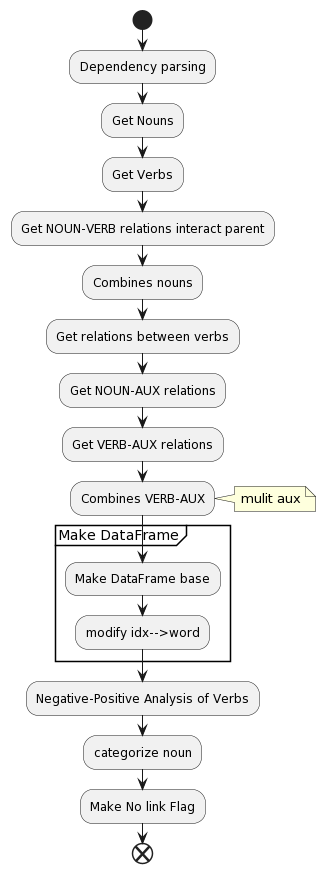

In [ ]:
with open('/content/sample.puml', 'w+') as f:
	f.write('''

@startuml
start
:Dependency parsing;
:Get Nouns;
:Get Verbs;
:Get NOUN-VERB relations interact parent;
:Combines nouns;
:Get relations between verbs;
:Get NOUN-AUX relations;
:Get VERB-AUX relations;
:Combines VERB-AUX;
note right
mulit aux
end note
group Make DataFrame
:Make DataFrame base;
:modify idx-->word;
end group
:Negative-Positive Analysis of Verbs;
:categorize noun;
:Make No link Flag;
end
@enduml

''')

!python -m plantuml sample.puml

from IPython.display import Image

Image('sample.png')

# Code

In [ ]:
import ginza
from spacy import displacy
import spacy
import sys
import pandas as pd
class DependencyAnalysis:
    def __init__(self):
        self.nlp = spacy.load('ja_ginza_electra')
        self.indecies = []
        self.noun_l=[]
        self.verb_l=[]
        self.noun_verb_relation_l=[]
        self.merged_cnoun_l=[]
        self.sent_cnt=0
        cols = ["sent_cnt","i", "orth", "base","head","dep","pos","tag"]
        # self.dependent_indecies_pd = pd.DataFrame(index=[], columns=cols)
        self.depend_indecies_df = pd.DataFrame(index=[], columns=cols)
        self.noun_df = pd.DataFrame(index=[], columns=cols)
        self.verb_df = pd.DataFrame(index=[], columns=cols)
        self.aux_df = pd.DataFrame(index=[], columns=cols)
        output_cols=["ID","NOUN","NOUN_AUX","Category","VERB","VERB_AUX","Pos/Neg","ProductID","Sent","Doc","Nolink",]
        self.output_df = pd.DataFrame(index=[], columns=cols)

    def get_analysis(self, text):
      #**use**
      """係り受け解析"""
      doc = self.nlp(text)
      token_head_list = []

      for sent in doc.sents:
        # self.sent_cnt+=1
        for token in sent:
          token_head_list.append(
            {"sent_cnt":self.sent_cnt,"i": token.i, "orth": token.orth_, "base": token.lemma_,
              "head": token.head.i, "dep": token.dep_,"pos":token.pos_,
              "tag":token.tag_})
          # depend_indecies_df_tmp=pd.DataFrame({"sent_cnt":self.sent_cnt,"i": [token.i],
          #                      "orth": [token.orth_], "base":[token.lemma_],
          #                      "head":[token.head.i], "dep": [token.dep_],
          #                      "pos":[token.pos_], "tag":[token.tag_]})
      self.depend_indecies_df_tmp=pd.DataFrame(token_head_list)
      self.depend_indecies_df= pd.concat([self.depend_indecies_df,self.depend_indecies_df_tmp])
      # print(token_head_list)

      displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})
      print("depend_indecies_df_tmp:",self.depend_indecies_df_tmp)


      return token_head_list
    # def get(self, text, target):
    #   # 係り受け解析
    #   self.depend_indecies = self.get_analysis(text)
    #   print(self.depend_indecies)

    def get_words(self,  m, head):
        """対象の領域の抽出"""

        if m["head"] == head :
            for n in self.depend_indecies:
                self.get_words(m=n, head=m["i"])

            self.indecies.append(m["i"])

        return
    def get(self, text, target):

        # 係り受け解析
        self.depend_indecies = self.get_analysis(text)
        # print(self.depend_indecies)
        for i in self.depend_indecies:
          print(i)

        # 係り元のインデックスを取得
        head = self.depend_indecies[target]["head"]
        # print(head)

        # 係り元のかかり先を探索
        self.indecies.append(head)
        print(self.indecies)#list of head?
        for m in self.depend_indecies:
            if m["head"] == head and m["dep"] != "ROOT":
                self.get_words(m, head=head)

        clause = ""
        for clause_num in sorted(self.indecies):
            clause = clause + str(self.depend_indecies[clause_num]["orth"])

        return clause



    def get_dat(self,df,get_clm,get_l,ex_clm,ex_l):
      # **use**
      df=df[df[get_clm].isin(get_l)]
      df=df[~df[ex_clm].isin(ex_l)]
      return df

    def get_noun_old(self):
      # **use**
      # print(type(self.depend_indecies))
      # noun_l=[i for i in self.depend_indecies if "名詞" in i["tag"]]

      ex_l=["こと"]
      pos_l=["NOUN","PROPN","NUM","SYM"]
      noun_l=[i for i in self.depend_indecies if "NOUN" in i["pos"] or "PROPN" in i["pos"] or "NUM" in i["pos"]or "SYM" in i["pos"]]
      noun_l=[i for i in noun_l if not i["base"] in ex_l]

      # self.noun_df_tmp=self.depend_indecies_df_tmp[self.depend_indecies_df_tmp["pos"].isin(pos_l)]
      # self.noun_df_tmp=self.noun_df_tmp[~self.noun_df_tmp["base"].isin(ex_l)]
      self.noun_df_tmp=self.get_dat(self.depend_indecies_df_tmp,"pos",pos_l,"base",ex_l)
      print("noun_df_tmp",self.noun_df_tmp)

      self.noun_df=pd.concat([self.noun_df,self.noun_df_tmp])
      # print("noun_df",self.noun_df)
      return noun_l

    def get_noun(self):
      # **use**

      ex_l=["こと"]
      pos_l=["NOUN","PROPN","NUM","SYM"]
      # noun_l=[i for i in self.depend_indecies if "NOUN" in i["pos"] or "PROPN" in i["pos"] or "NUM" in i["pos"]or "SYM" in i["pos"]]
      # noun_l=[i for i in noun_l if not i["base"] in ex_l]

      self.noun_df_tmp=self.get_dat(self.depend_indecies_df_tmp,"pos",pos_l,"base",ex_l)
      print("noun_df_tmp",self.noun_df_tmp)

      self.noun_df=pd.concat([self.noun_df,self.noun_df_tmp])
      # print("noun_df",self.noun_df)
      # return noun_l

    def get_verb(self):
      # **use**
      # verb_l=[i for i in self.depend_indecies if "VERB" in i["pos"]]
      ex_l=["する","おく"]
      pos_l=["VERB"]
      # verb_l=[i for i in verb_l if not i["base"] in ex_l]
      # print(verb_l)

      # self.verb_df=self.depend_indecies_df[self.depend_indecies_df["pos"]=="VERB"]
      # self.verb_df=self.verb_df[self.verb_df["base"].isin(ex_l)]
      # print(self.verb_df)
      self.verb_df_tmp=self.get_dat(self.depend_indecies_df_tmp,"pos",pos_l,"base",ex_l)
      print("verb_df_tmp",self.verb_df_tmp)
      self.verb_df=pd.concat([self.verb_df,self.verb_df_tmp])
      # return verb_l

    def get_aux(self):
      # **use**
      # aux_l=[i for i in self.depend_indecies if "AUX" in i["pos"]]
      ex_l=[]
      pos_l=["AUX"]
      # aux_l=[i for i in aux_l if not i["base"] in ex_l]

      self.aux_df_tmp=self.get_dat(self.depend_indecies_df_tmp,"pos",pos_l,"base",ex_l)
      print("aux_df_tmp",self.aux_df_tmp)
      self.aux_df=pd.concat([self.aux_df,self.aux_df_tmp])
      # return aux_l

    def seek_verb(self,noun,seek="VERB"):
      #Find verb from noun
      if noun is None:
        return
      parents_idx=noun["head"]
      if noun["i"]==noun["head"]:
        # print("same index")
        return
      # print(parents_idx)
      if self.depend_indecies[parents_idx]["pos"]=="VERB":
        # print("VERB",self.depend_indecies[parents_idx])
        return self.depend_indecies[parents_idx]
        # print("error")
      elif self.depend_indecies[parents_idx]["dep"]=="ROOT":
        print("ROOT END")
        return
      else:
        # print("loop")
        return self.seek_verb(self.depend_indecies[parents_idx])

    def seek_ances_word_df(self,series,seek_wrd):
      # **use**
      #Find ancestor word from df
      parents_idx=series["head"]
      # print(parents_idx)
      p_dat=self.depend_indecies_df_tmp[(self.depend_indecies_df_tmp["i"]==parents_idx)]
      p_dat=p_dat.iloc[0,:]
      pos=p_dat["pos"]
      if pos==seek_wrd:
        # print("pos",pos)
        # print(type(pos))
        # print(p_dat)
        return p_dat["i"]
        # print("error")
      elif p_dat["dep"]=="ROOT":
        # print("ROOT END")
        return
      else:
        # print("loop")
        # print("**series**",series)
        # print("p_dat*:",p_dat)
        # print("-"*10)
        return self.seek_ances_word_df(p_dat,seek_wrd)

    def seek_word(self,noun,seek):
      #Find verb from noun
      if noun is None:
        return
      parents_idx=noun["head"]
      if noun["i"]==noun["head"]:
        # print("same index")
        return
      # print(parents_idx)
      if self.depend_indecies[parents_idx]["pos"]==seek:
        # print("VERB",self.depend_indecies[parents_idx])
        return self.depend_indecies[parents_idx]
        # print("error")
      elif self.depend_indecies[parents_idx]["dep"]=="ROOT":
        # print("ROOT END")
        return
      else:
        # print("loop")
        return self.seek_word(self.depend_indecies[parents_idx],seek)

    def merge_set(self,set_l):
      merged_set_l=[]
      if len(set_l)==1:
        merged_set_l=set_l
        return merged_set_l

      for i in range(len(set_l)):
        itm=set_l.pop(0)
        # print("loop",i)
        # print("list:",set_l)
        # print("i:",i,"pop itm:",itm)
        flag=False
        # print("len(set_l)",len(set_l))
        if len(set_l)==0:
          itm_l=list(itm)
          itm_l.sort()
          merge_word=self.make_compound_word(itm_l)
          merged_set_l.append([itm_l,merge_word])
          # print("len=0 break")
          break
        for idx,j in enumerate(set_l):
          if len(itm & j) !=0:
            mrg=itm | j
            set_l[idx]=mrg
            flag=True
            # print("merge:",mrg)
            break
        if flag==False:
          itm_l=list(itm)
          itm_l.sort()
          merge_word=self.make_compound_word(itm_l)
          merged_set_l.append([itm_l,merge_word])
        # print("merged list:",merged_set_l)
        # print("-"*10)
      # print("="*100)
      # print(merged_set_l)
      # print("="*100)
      return merged_set_l

    def make_compound_word(self,merged_cnoun_l):
      cnoun=""
      for i in merged_cnoun_l:
        # print("i",i)
        for l in self.depend_indecies:
          if l["i"]==i:
            cnoun+=l["orth"]
      # print(cnoun)
      return cnoun

    def make_compound_nouns_old(self):
      print(self.depend_indecies)
      # find compound and nummod
      cnoun_l=[[i,self.depend_indecies[i["head"]]] for i in self.depend_indecies if i["dep"]=="compound" or i["dep"]=="nummod"]

      #find compound index
      merge_cnoun_l=[{m["i"] for m in l} for l in cnoun_l]
      # print("merge_cnoun_l:",merge_cnoun_l)

      #merge noun
      merged_cnoun_l=[]
      # merge_cnoun_l=[{0,1}]
      if len(merge_cnoun_l)==1:
        # print("merge cnoun_l=1:",merge_cnoun_l)
        itm_l=list(merge_cnoun_l[0])
        itm_l.sort()
        merge_word=self.make_compound_word(itm_l)
        merged_cnoun_l.append([itm_l,merge_word])
      else:
        merged_cnoun_l=self.merge_set(merge_cnoun_l)
        # print("merged cnoun_l:",merged_cnoun_l)

      return merged_cnoun_l

    def make_compound_nouns(self):
      # print(self.depend_indecies)
      # find compound and nummod
      # cnoun_l=[[i,self.depend_indecies[i["head"]]] for i in self.depend_indecies if i["dep"]=="compound" or i["dep"]=="nummod"]
      # print("cnoun_l",cnoun_l)

      dep_l=["compound","nummod"]

      # cnoun_tmp_df=self.depend_indecies_df_tmp[self.depend_indecies_df_tmp["dep"].isin(dep_l)]
      cnoun_tmp_df=self.noun_df_tmp[self.noun_df_tmp["dep"].isin(dep_l)]
      i_l_df=cnoun_tmp_df[["i","head"]]
      merge_cnoun_l=[{i[1]["i"],i[1]["head"]} for i in i_l_df.iterrows()]

      ##filtter noun
      # print("*"*10)
      # for i in i_l_df.iterrows():
      #   print(i)
      #   tmp=self.depend_indecies_df_tmp[(self.depend_indecies_df_tmp["i"]==i[1]["i"])]["pos"]
      #   print(tmp)
      # print("cnoun_l from df:",merge_cnoun_l)
      # print("df cnoun_l:",i_l_df)
      merge_cnoun_l2=[]

      #find compound index
      # merge_cnoun_l=[{m["i"] for m in l} for l in cnoun_l]
      print("merge_cnoun_l:",merge_cnoun_l)
      # sys.exit( )

      #merge noun
      merged_cnoun_l=[]
      # merge_cnoun_l=[{0,1}]
      if len(merge_cnoun_l)==1:
        # print("merge cnoun_l=1:",merge_cnoun_l)
        itm_l=list(merge_cnoun_l[0])
        itm_l.sort()
        merge_word=self.make_compound_word(itm_l)
        merged_cnoun_l.append([itm_l,merge_word])
      else:
        merged_cnoun_l=self.merge_set(merge_cnoun_l)
        # print("merged cnoun_l:",merged_cnoun_l)

      return merged_cnoun_l



    def seek_noun_all(self,noun,cnoun_l):
      #Find noun from noun
      parents_idx=noun["head"]
      # print(parents_idx)

      if noun["dep"]=="compound" or noun["dep"]=="nummod":
        cnoun_l.append(self.depend_indecies[parents_idx])
      else:
        return cnoun_l

      '''
      if self.depend_indecies[parents_idx]["pos"]=="NOUN" or self.depend_indecies[parents_idx]["pos"]=="PROPN" or self.depend_indecies[parents_idx]["pos"]=="NUM":
        cnoun_l.append(self.depend_indecies[parents_idx])
        # print("VERB",self.depend_indecies[parents_idx])
        return self.seek_noun_all(self.depend_indecies[parents_idx],cnoun_l)
        # print("error")
      else:
        return cnoun_l
      '''
    def get_noun_verb_rel(self):
        noun_verb_rel_l=[]
        for i in self.noun_l:
          # print("noun:",i)
          verb=self.seek_verb(i)
          # print("verb:",verb)
          tmp=[i,verb]
          noun_verb_rel_l.append(tmp)

        self.noun_verb_relation_l=noun_verb_rel_l

    def get_unique_list(self,seq):
      #Remove duplicates from the list
        seen = []
        return [x for x in seq if x not in seen and not seen.append(x)]

    def get_verb_verb_rel(self):
        verb_verb_l=[]
        for i in self.noun_verb_relation_l:
          prt_idx=self.seek_verb(i[1])
          # print("verb:",i[1])
          # print("prt_verb:",prt_idx)
          if prt_idx is not None:
            tmp_l=[i[1]["i"],prt_idx["i"]]
            verb_verb_l.append(tmp_l)
        # print(verb_verb_l)
        return self.get_unique_list(verb_verb_l)

    def get_rel(self,word_l,seek_str):
        rel_l=[]
        for i in word_l:
          # print("noun:",i)
          verb=self.seek_word(i,seek_str)
          # print("verb:",verb)
          if verb is not None:
            tmp=[i["i"],verb]
            rel_l.append(tmp)
        return rel_l

    def get_rel_prt_df(self,word_df,seek_str):
      # **use**
      # print(type(word_df))
      rel_l=[]
      for itm  in word_df.iterrows():
        # print(type(itm))
        # print(itm)
        i=itm[1]["i"]
        val=self.depend_indecies_df_tmp[(self.depend_indecies_df_tmp["i"]==itm[1]["head"])&(self.depend_indecies_df_tmp["pos"]==seek_str)]
        if not val.empty:
          # print("i:",i)
          # print("head:",itm[1]["head"])
          val=val["i"].iloc[0]
          if i !=val:
            continue
          # print("pos:",val)
          rel_l.append([i,val])

      print(rel_l)
      print("-"*10)
      return rel_l

    def get_rel_prt_intr_df(self,df1,df2):
      # **use**
      # print("df1:",df1)
      # print("df2:",df2)
      rel_l=[]
      i1_l=list(df1["i"].values)
      i2_l=list(df2["i"].values)
      # print("df2:",i2_l)
      for i in i1_l:
        head=df1[(df1["i"]==i)]["head"].iloc[0]
        if head  in i2_l:
          rel_l.append([i,head])

      for i in i2_l:
        head=df2[(df2["i"]==i)]["head"].iloc[0]
        if head  in i1_l:
          rel_l.append([i,head])
      # print(rel_l)

      return rel_l
      # for itm  in word_df.iterrows():
      #   # print(type(itm))
      #   # print(itm)
      #   i=itm[1]["i"]
      #   val=self.depend_indecies_df_tmp[(self.depend_indecies_df_tmp["i"]==itm[1]["head"])&(self.depend_indecies_df_tmp["pos"]==seek_str)]
      #   if not val.empty:
      #     # print("i:",i)
      #     # print("head:",itm[1]["head"])
      #     val=val["i"].iloc[0]
      #     if i !=val:
      #       continue
      #     # print("pos:",val)
      #     rel_l.append([i,val])

      # print(rel_l)
      # print("-"*10)
      # return rel_l

    def get_rel_df(self,df,pos_str,df2):
      # **use**
      df2_idx_l=list(df2["i"])
      # print(df2_idx_l)

      if df.empty:
        return
      rel_l=[]
      for i in df.iterrows():
        # print(i[1]["i"],type(i[1]))
        stop_idx=self.seek_ances_word_df(i[1],pos_str)
        # print(type(stop_idx))
        # print("stop:",stop_idx)
        if i[1]["i"]!= stop_idx and stop_idx is not None and stop_idx in df2_idx_l:
          rel_l.append([i[1]["i"],stop_idx])

      # print("output:",rel_l)
      return rel_l

    def make_output_df(self):
      dat_idx_l=[]
      # dat_tmp_dict=[]
      dat_tmp_l=[]
      noun_l=list(self.noun_df_tmp["i"])
      verb_l=list(self.verb_df_tmp["i"])
      aux_l=list(self.aux_df_tmp["i"])

      #add noun
      dat_idx_l=[{"Sent":self.sent_cnt,"NOUN":{i},"NOUN_AUX":None,"VERB":None,"VERB_AUX":None} for i in noun_l]
      #adj cnoun
      for i in dat_idx_l:
        for l in self.merged_cnoun_l:
          # print(i["NOUN"])
          if i["NOUN"].issubset(set(l[0])):
            i["NOUN"]=set(l[0])

      for i in dat_idx_l:
        # print(i)
        #noun_verb
        for l in self.noun_verb_l:
          if l[0] in noun_l:
            #case l[0] is noun
            if l[0] in i["NOUN"]:
              i["VERB"]=l[1]
          elif l[0] in verb_l:
            #case l[1] is noun
            if l[1] in i["NOUN"]:
              i["VERB"]=l[0]
        #noun_aux
        for l in self.noun_aux_l:
          if l[0] in noun_l:
            if l[0] in noun_l:
              i["NOUN_AUX"]=l[1]
          elif l[0] in aux_l:
            if l[1] in i["NOUN"]:
              i["NOUN_AUX"]=l[0]
        #verb_aux
        for l in self.verb_aux_l:
          if l[0] in verb_l:
            if i["VERB"]==l[0]:
              if i["VERB_AUX"] is None:
                i["VERB_AUX"]={l[1]}
              else:
                i["VERB_AUX"].add(l[1])
          elif l[0] in aux_l:
            if i["VERB"]==l[1]:
              if i["VERB_AUX"] is None:
                i["VERB_AUX"]={l[0]}
              else:
                i["VERB_AUX"].add(l[0])
        print(i)

      #change idx to word
      self.change_idx_l_to_word_l(dat_idx_l)

      # print("dat_tmp_idx_dict",dat_tmp_idx_dict)
      # noun_wrd=self.chanege_idx_to_word(self.noun_df_tmp,dat_tmp_idx_dict["NOUN"])
      # verb_wrd=self.chanege_idx_to_word(self.verb_df_tmp,dat_tmp_idx_dict["VERB"])
      # noun_aux_wrd=self.chanege_idx_to_word(self.aux_df_tmp,dat_tmp_idx_dict["NOUN_AUX"])
      # verb_aux_wrd=self.chanege_idx_to_word(self.aux_df_tmp,dat_tmp_idx_dict["VERB_AUX"])
      # dat_tmp_dict={"NOUN":noun_wrd,"NOUN_AUX":noun_aux_wrd,"VERB":verb_wrd,"VERB_AUX":verb_aux_wrd}
      # print("dat_tmp_dict",dat_tmp_dict)

      #change to df

      #exclude the same data


      print("dat_tmp_l",dat_tmp_l)

      #get noun only
    def make_output_df_old(self):
      #get noun-verb
      dat_tmp_idx=[]
      dat_idx_l=[]
      dat_tmp_dict=[]
      dat_tmp_l=[]
      for i in self.noun_verb_l:
        dat_tmp_idx_dict={"Sent":self.sent_cnt,"NOUN":i[0],"NOUN_AUX":None,"VERB":i[1],"VERB_AUX":None}
        #get noun-aux
        for k in self.noun_aux_l:
          if k[0]==dat_tmp_idx_dict["NOUN"]:
            dat_tmp_idx_dict["NOUN_AUX"]=k[1]
            # break
          elif  k[1]==dat_tmp_idx_dict["NOUN"]:
            dat_tmp_idx_dict["NOUN_AUX"]=k[0]
            # break
        #get verb-aux
        for k in self.verb_aux_l:
          if k[0]==dat_tmp_idx_dict["VERB"]:
            dat_tmp_idx_dict["VERB_AUX"]=k[1]
            # break
          elif k[1]==dat_tmp_idx_dict["VERB"]:
            dat_tmp_idx_dict["VERB_AUX"]=k[0]
            # break
        dat_idx_l.append(dat_tmp_idx_dict)

      #add noun ex noun-verb
      noun_verb_noun_set=set([i[0] for i in self.noun_verb_l])
      #add noun-aux****

      # print(noun_verb_noun_set)
      noun_set=set(self.noun_df_tmp["i"])
      noun_diff_set=noun_set-noun_verb_noun_set
      # print(noun_diff_set)
      if len(noun_diff_set)!=0:
        for i in noun_diff_set:
          dat_tmp_idx_dict={"Sent":self.sent_cnt,"NOUN":i,"NOUN_AUX":None,"VERB":None,"VERB_AUX":None}
          dat_idx_l.append(dat_tmp_idx_dict)
        # sys.exit()

      for i in dat_idx_l:
        print(i)

      #change idx to word
      self.change_idx_l_to_word_l(dat_idx_l)

      # print("dat_tmp_idx_dict",dat_tmp_idx_dict)
      # noun_wrd=self.chanege_idx_to_word(self.noun_df_tmp,dat_tmp_idx_dict["NOUN"])
      # verb_wrd=self.chanege_idx_to_word(self.verb_df_tmp,dat_tmp_idx_dict["VERB"])
      # noun_aux_wrd=self.chanege_idx_to_word(self.aux_df_tmp,dat_tmp_idx_dict["NOUN_AUX"])
      # verb_aux_wrd=self.chanege_idx_to_word(self.aux_df_tmp,dat_tmp_idx_dict["VERB_AUX"])
      # dat_tmp_dict={"NOUN":noun_wrd,"NOUN_AUX":noun_aux_wrd,"VERB":verb_wrd,"VERB_AUX":verb_aux_wrd}
      # print("dat_tmp_dict",dat_tmp_dict)

      #change to df

      #exclude the same data


      print("dat_tmp_l",dat_tmp_l)

      #get noun only

    def change_idx_l_to_word_l(self,dat_l):
      word_l=[]
      for i in dat_l:
        if len(i["NOUN"])!=1:
          #change cnoun
          for j in self.merged_cnoun_l:
            if i["NOUN"] == set(j[0]):
              # print("merged cnoun:",j[1])
              i["NOUN"]=j[1]
              # print("cnoun:",i)
        else:
          #change noun
          i["NOUN"]=self.depend_indecies_df_tmp[self.depend_indecies_df_tmp["i"]==i["NOUN"].pop()]["base"].iloc[-1]
          print("noun:",i)
        #change noun_aux
        if i["NOUN_AUX"] is not None:
          i["NOUN_AUX"]=self.depend_indecies_df_tmp[self.depend_indecies_df_tmp["i"]==i["NOUN_AUX"]]["base"].iloc[-1]
        #change verb_aux
        if i["VERB_AUX"] is not None:
          if len(i["VERB_AUX"])==1:
            i["VERB_AUX"]=self.depend_indecies_df_tmp[self.depend_indecies_df_tmp["i"]==i["VERB_AUX"].pop()]["base"].iloc[-1]
          else:
            val=""
            # print(i["VERB_AUX"])
            i_l=list(i["VERB_AUX"])
            i_l.sort()
            for l in i_l:
              val=val+self.depend_indecies_df_tmp[self.depend_indecies_df_tmp["i"]==l]["orth"].iloc[-1]
            i["VERB_AUX"]=val
            # print(i["VERB_AUX"])
        #change verb
        if i["VERB"] is not None:
          i["VERB"]=self.depend_indecies_df_tmp[self.depend_indecies_df_tmp["i"]==i["VERB"]]["base"].iloc[-1]

        #add list
        word_l.append(i)
      print(word_l)
      #change to dataframe
      df=pd.DataFrame(word_l)
      #remove same data
      print(df)

      return word_l

    def chanege_idx_to_word(self,df,idx):
      if idx is None:
        return
      for i in self.merged_cnoun_l:
        if idx in i[0]:
          print("merged cnoun:",i[1])
          return i[1]
      return df[df["i"]==idx]["base"].iloc[-1]

    def dep_analysis_main(self,text):
        # 係り受け解析
        self.depend_indecies = self.get_analysis(text)

        # print(self.depend_indecies)
        # for i in self.depend_indecies:
        #   print(i)
        # print("-"*100)

        #get NOUN
        self.noun_l=self.get_noun()
        # for l in self.noun_l:
        #   print(l)

        #get VERB
        self.verb_l=self.get_verb()
        # for l in verb_l:
        #   print(l)

        #get AUX
        self.aux_l=self.get_aux()

        #get NOUN-VERB relations
        # self.noun_verb_l=self.get_rel_df(self.noun_df_tmp,"VERB",self.verb_df_tmp)
        self.noun_verb_l=self.get_rel_prt_intr_df(self.noun_df_tmp,self.verb_df_tmp)
        print("noun-verb list:",self.noun_verb_l)
        # print("noun-verb list2:",self.noun_verb_l2)

        # self.get_noun_verb_rel()
        # for i in self.noun_verb_relation_l:
        #   print("noun:",i[0])
        #   print("verb:",i[1])
        # print("-"*100)
        # sys.exit()

        #get compound nouns
        # for i in noun_l:
          # c_cnouns_l=self.make_compound_nouns(i)
        # print(noun_l[0])
        self.merged_cnoun_l=self.make_compound_nouns()
        print("merged cnoun list:",self.merged_cnoun_l)

        #get VERB-VERB relations
        # verb_verb_l=self.get_verb_verb_rel()

        verb_verb_l=self.get_rel_df(self.verb_df_tmp,"VERB",self.verb_df_tmp)
        print("verb-verb list:",verb_verb_l)

        #Get NOUN-AUX relations;
        # self.noun_aux_rel=self.get_rel(self.noun_l,"AUX")
        # self.noun_aux_rel=self.get_rel_df(self.noun_df_tmp,"AUX")
        self.noun_aux_l=self.get_rel_prt_intr_df(self.noun_df_tmp,self.aux_df_tmp)
        print("noun-aux list:",self.noun_aux_l)

        #Get VERB-AUX relations;
        # self.get_rel_prt_df(self.noun_df,"VERB")
        self.verb_aux_l=self.get_rel_prt_intr_df(self.verb_df_tmp,self.aux_df_tmp)
        # self.verb_aux_l2=self.get_rel_df(self.verb_df_tmp,"AUX",self.aux_df_tmp)
        # self.verb_aux_l3=self.get_rel_df(self.aux_df_tmp,"VERB",self.verb_df_tmp)
        print("verb-aux list:",self.verb_aux_l)
        # print("verb-aux list2:",self.verb_aux_l2)
        # print("verb-aux list3:",self.verb_aux_l3)

        #Make DataFrame;
        self.make_output_df()
        print(self.output_df)

        #Make No link Flag;

        #Negative-Positive Analysis of Verbs;


if __name__ == '__main__':
  dependency = DependencyAnalysis()
  txt_l=["下流あごを2mmだすと分離は改善するが、コンタミが悪化する。",
         "非通紙部昇温時のxx75において発生する。",
         "下流あごを出すこととオフセットを0.2mmにすることより解決する",
         "上流あごは分離に影響を与えない。オフセットの増加は分離に関係ない",
         "下流あごの増加による分離悪化を説明できない",
         "下流あごと分離は無関係である",
         "オフセットと分離は関係ある",
         "上流オフセットでは分離は改善しない"]
  # ret=dependency.get_analysis("下流あごをだすと分離は改善するが、コンタミが悪化する")
  # for i in ret:
    # print(i)
  for txt in txt_l:
    # ret=dependency.get(txt,0)
    # print(ret)
    dependency.sent_cnt+=1
    dependency.dep_analysis_main(txt)
  print(dependency.depend_indecies_df)
  print(dependency.noun_df)
  print(dependency.verb_df)


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
error [Errno 2] No such file or directory: '/root/.cache/huggingface/hub/models--megagonlabs--transformers-ud-japanese-electra-base-ginza-510/refs/main'
error Can't load the configuration of '/tmp/tmpiqqz07i5/config.json'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure '/tmp/tmpiqqz07i5/config.json' is the correct path to a directory containing a config.json file
trying to download model from huggingface hub: megagonlabs/transformers-ud-japanese-electra-base-ginza-510 ...


Downloading:   0%|          | 0.00/815 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/434M [00:00<?, ?B/s]

succeded


depend_indecies_df_tmp:     sent_cnt   i  orth  base  head       dep    pos            tag
0          1   0    下流    下流     1  compound   NOUN     名詞-普通名詞-一般
1          1   1    あご    あご     5       obj   NOUN     名詞-普通名詞-一般
2          1   2     を     を     1      case    ADP         助詞-格助詞
3          1   3     2     2     4    nummod    NUM          名詞-数詞
4          1   4    mm    mm     5       obl   NOUN  名詞-普通名詞-助数詞可能
5          1   5    だす    だす     9     advcl   VERB       動詞-非自立可能
6          1   6     と     と     5      mark  SCONJ        助詞-接続助詞
7          1   7    分離    分離     9     nsubj   NOUN   名詞-普通名詞-サ変可能
8          1   8     は     は     7      case    ADP         助詞-係助詞
9          1   9    改善    改善    15     advcl   VERB   名詞-普通名詞-サ変可能
10         1  10    する    する     9       aux    AUX       動詞-非自立可能
11         1  11     が     が     9      mark  SCONJ        助詞-接続助詞
12         1  12     、     、     9     punct  PUNCT        補助記号-読点
13         1  13  コンタミ  コンタミ    15    

depend_indecies_df_tmp:     sent_cnt   i orth base  head       dep    pos            tag
0          2   0    非    非     5  compound   NOUN            接頭辞
1          2   1    通    通     5  compound   NOUN  名詞-普通名詞-形状詞可能
2          2   2    紙    紙     5  compound   NOUN     接尾辞-名詞的-一般
3          2   3    部    部     5  compound   NOUN  名詞-普通名詞-助数詞可能
4          2   4   昇温   昇温     5  compound   NOUN     名詞-普通名詞-一般
5          2   5    時    時     8      nmod   NOUN  名詞-普通名詞-助数詞可能
6          2   6    の    の     5      case    ADP         助詞-格助詞
7          2   7   xx   xx     8  compound    SYM     名詞-普通名詞-一般
8          2   8   75   75    12       obl    NUM          名詞-数詞
9          2   9    に    に     8      case    ADP         助詞-格助詞
10         2  10   おい   おく     9     fixed   VERB          動詞-一般
11         2  11    て    て     9     fixed  SCONJ        助詞-接続助詞
12         2  12   発生   発生    12      ROOT   VERB   名詞-普通名詞-サ変可能
13         2  13   する   する    12       aux    AUX       動詞-非自立可能
1

depend_indecies_df_tmp:     sent_cnt   i   orth   base  head       dep   pos            tag
0          3   0     下流     下流     1  compound  NOUN     名詞-普通名詞-一般
1          3   1     あご     あご     3       obj  NOUN     名詞-普通名詞-一般
2          3   2      を      を     1      case   ADP         助詞-格助詞
3          3   3     出す     出す     4       acl  VERB       動詞-非自立可能
4          3   4     こと     こと    12      nmod  NOUN     名詞-普通名詞-一般
5          3   5      と      と     4      case   ADP         助詞-格助詞
6          3   6  オフセット  オフセット    11       obj  NOUN     名詞-普通名詞-一般
7          3   7      を      を     6      case   ADP         助詞-格助詞
8          3   8    0.2    0.2     9  compound   NUM          名詞-数詞
9          3   9     mm     mm    11       obl  NOUN  名詞-普通名詞-助数詞可能
10         3  10      に      に     9      case   ADP         助詞-格助詞
11         3  11     する     する    12       acl  VERB       動詞-非自立可能
12         3  12     こと     こと    14       obl  NOUN     名詞-普通名詞-一般
13         3  13     より 

depend_indecies_df_tmp:     sent_cnt   i   orth   base  head       dep    pos           tag
0          4   0     上流     上流     1  compound   NOUN    名詞-普通名詞-一般
1          4   1     あご     あご     7     nsubj   NOUN    名詞-普通名詞-一般
2          4   2      は      は     1      case    ADP        助詞-係助詞
3          4   3     分離     分離     7       obl   NOUN  名詞-普通名詞-サ変可能
4          4   4      に      に     3      case    ADP        助詞-格助詞
5          4   5     影響     影響     7       obj   NOUN  名詞-普通名詞-サ変可能
6          4   6      を      を     5      case    ADP        助詞-格助詞
7          4   7     与え    与える     7      ROOT   VERB         動詞-一般
8          4   8     ない     ない     7       aux    AUX           助動詞
9          4   9      。      。     7     punct  PUNCT       補助記号-句点
10         4  10  オフセット  オフセット    12      nmod   NOUN    名詞-普通名詞-一般
11         4  11      の      の    10      case    ADP        助詞-格助詞
12         4  12     増加     増加    16     nsubj   NOUN  名詞-普通名詞-サ変可能
13         4  13      は 

depend_indecies_df_tmp:     sent_cnt   i orth base  head       dep   pos           tag
0          5   0   下流   下流     1  compound  NOUN    名詞-普通名詞-一般
1          5   1   あご   あご     3      nmod  NOUN    名詞-普通名詞-一般
2          5   2    の    の     1      case   ADP        助詞-格助詞
3          5   3   増加   増加     7      nmod  NOUN  名詞-普通名詞-サ変可能
4          5   4    に    に     3      case   ADP        助詞-格助詞
5          5   5   よる   よる     4     fixed  VERB         動詞-一般
6          5   6   分離   分離     7  compound  NOUN  名詞-普通名詞-サ変可能
7          5   7   悪化   悪化     9       obj  NOUN  名詞-普通名詞-サ変可能
8          5   8    を    を     7      case   ADP        助詞-格助詞
9          5   9   説明   説明     9      ROOT  VERB  名詞-普通名詞-サ変可能
10         5  10   でき  できる     9       aux   AUX      動詞-非自立可能
11         5  11   ない   ない     9       aux   AUX           助動詞
noun_df_tmp    sent_cnt  i orth base  head       dep   pos           tag
0         5  0   下流   下流     1  compound  NOUN    名詞-普通名詞-一般
1         5  1   あご   あ

depend_indecies_df_tmp:    sent_cnt  i orth base  head       dep   pos            tag
0         6  0   下流   下流     1  compound  NOUN     名詞-普通名詞-一般
1         6  1   あご   あご     3      nmod  NOUN     名詞-普通名詞-一般
2         6  2    と    と     1      case   ADP         助詞-格助詞
3         6  3   分離   分離     5     nsubj  NOUN   名詞-普通名詞-サ変可能
4         6  4    は    は     3      case   ADP         助詞-係助詞
5         6  5  無関係  無関係     5      ROOT  NOUN  名詞-普通名詞-形状詞可能
6         6  6    で    だ     5       cop   AUX            助動詞
7         6  7   ある   ある     6     fixed  VERB       動詞-非自立可能
noun_df_tmp    sent_cnt  i orth base  head       dep   pos            tag
0         6  0   下流   下流     1  compound  NOUN     名詞-普通名詞-一般
1         6  1   あご   あご     3      nmod  NOUN     名詞-普通名詞-一般
3         6  3   分離   分離     5     nsubj  NOUN   名詞-普通名詞-サ変可能
5         6  5  無関係  無関係     5      ROOT  NOUN  名詞-普通名詞-形状詞可能
verb_df_tmp    sent_cnt  i orth base  head    dep   pos       tag
7         6  7   ある   ある     6

depend_indecies_df_tmp:    sent_cnt  i   orth   base  head       dep   pos           tag
0         7  0  オフセット  オフセット     2      nmod  NOUN    名詞-普通名詞-一般
1         7  1      と      と     0      case   ADP        助詞-格助詞
2         7  2     分離     分離     4     nsubj  NOUN  名詞-普通名詞-サ変可能
3         7  3      は      は     2      case   ADP        助詞-係助詞
4         7  4     関係     関係     4      ROOT  NOUN  名詞-普通名詞-サ変可能
5         7  5     ある     ある     4  compound  VERB      動詞-非自立可能
noun_df_tmp    sent_cnt  i   orth   base  head    dep   pos           tag
0         7  0  オフセット  オフセット     2   nmod  NOUN    名詞-普通名詞-一般
2         7  2     分離     分離     4  nsubj  NOUN  名詞-普通名詞-サ変可能
4         7  4     関係     関係     4   ROOT  NOUN  名詞-普通名詞-サ変可能
verb_df_tmp    sent_cnt  i orth base  head       dep   pos       tag
5         7  5   ある   ある     4  compound  VERB  動詞-非自立可能
aux_df_tmp Empty DataFrame
Columns: [sent_cnt, i, orth, base, head, dep, pos, tag]
Index: []
noun-verb list: [[5, 4]]
merge_cnoun_l: []

depend_indecies_df_tmp:    sent_cnt  i   orth   base  head       dep   pos           tag
0         8  0     上流     上流     1  compound  NOUN    名詞-普通名詞-一般
1         8  1  オフセット  オフセット     6       obl  NOUN    名詞-普通名詞-一般
2         8  2      で      で     1      case   ADP        助詞-格助詞
3         8  3      は      は     1      case   ADP        助詞-係助詞
4         8  4     分離     分離     6     nsubj  NOUN  名詞-普通名詞-サ変可能
5         8  5      は      は     4      case   ADP        助詞-係助詞
6         8  6     改善     改善     6      ROOT  VERB  名詞-普通名詞-サ変可能
7         8  7      し     する     6       aux   AUX      動詞-非自立可能
8         8  8     ない     ない     6       aux   AUX           助動詞
noun_df_tmp    sent_cnt  i   orth   base  head       dep   pos           tag
0         8  0     上流     上流     1  compound  NOUN    名詞-普通名詞-一般
1         8  1  オフセット  オフセット     6       obl  NOUN    名詞-普通名詞-一般
4         8  4     分離     分離     6     nsubj  NOUN  名詞-普通名詞-サ変可能
verb_df_tmp    sent_cnt  i orth base  head   dep   pos

# Knowlege Graph


## pip

In [ ]:
!pip install -U ginza ja_ginza
# !pip uninstall ginza
# !pip uninstall ja_ginza
# !pip uninstall ja_ginza_electra
!pip install -U ginza ja_ginza_electra
# !pip install -U ginza https://github.com/megagonlabs/ginza/releases/download/latest/ja_ginza_electra-latest-with-model.tar.gz

## ユーザ辞書作成

※content以下にuser_dic.csvをいれる

user_dic.csv:googledriveの python/NLP/user_dict.csvに保存してあるファイルを使用

### 1.user_dicファイル作成

#### 既存のユーザ辞書のファイル削除

In [69]:
%ls
%rm user.dic
%rm user_dic.csv

drive/  sample_data/  user.dic  user_dic.csv


#### ユーザ辞書の移動

In [70]:
%cd ~
%cd ..
%mv user_dic.csv content/user_dic.csv
%cd content

/root
/
/content


#### ユーザ辞書の変換

In [71]:
!sudachipy ubuild -s /usr/local/lib/python3.10/dist-packages/sudachidict_core/resources/system.dic user_dic.csv

/content/user_dic.csv -> 36 in 0.00 sec
validate -> 36 in 0.00 sec
pos_table -> 32 in 0.00 sec
conn_matrix -> 36 in 0.00 sec
trie -> 2052 in 0.00 sec
word_id table -> 184 in 0.00 sec
word_params -> 220 in 0.00 sec
wordinfo_offsets -> 144 in 0.00 sec
wordinfos (copy only) -> 1308 in 0.00 sec


### 2.sudachi.jsonへのユーザ辞書ファイルのパス追加

In [72]:
import sys
import os

# システム辞書のパスを探す
sys_dic_path = ''
for path in sys.path:
    path = path+'/sudachidict_core/resources/system.dic'
    if os.path.exists(path):
        sys_dic_path = path
        break
print('sys_dic_path:', sys_dic_path)

# ユーザー辞書のパスを設定
user_dic_path = os.getcwd()+'/user.dic'
print('user_dic_path:', user_dic_path)

# sudachi.jsonのパスを探す
sudachi_path = None
for path in sys.path:
    path = path+'/sudachipy/resources/sudachi.json'
    if os.path.exists(path):
        sudachi_path = path
        break
print('sudachi_path:', sudachi_path)

# sudachi.jsonにユーザー辞書のパスを追加
if sudachi_path != None:
    lines = []
    with open(sudachi_path) as f:
        lines = f.readlines()
    for i in range(len(lines)-1):
        if lines[i].find('"characterDefinitionFile"') >= 0 and lines[i+1].find('"userDict"') < 0:
            lines.insert(i+1,'    "userDict" : ["'+user_dic_path+'"],\n')
            with open(sudachi_path, 'w', encoding='utf-8', newline='\n') as f:
                f.writelines(lines)
            print('update')
            break

sys_dic_path: /usr/local/lib/python3.10/dist-packages/sudachidict_core/resources/system.dic
user_dic_path: /content/user.dic
sudachi_path: /usr/local/lib/python3.10/dist-packages/sudachipy/resources/sudachi.json


↑sudachi.jsonのパス

## ユーザ指定のカテゴリ分類追加

In [42]:
import sys
import os

sudachi_path="/usr/local/lib/python3.10/dist-packages/spacy/lang/ja/tag_map.py"
lines = []
add_txts=['   "名詞-固有名詞-一般-製品名": {POS: PROPN},\n',
    '   "名詞-固有名詞-一般-紙": {POS: PROPN},\n',
    '   "名詞-固有名詞-一般-設計パラメータ": {POS: PROPN},\n',
    '   "名詞-固有名詞-一般-特性値": {POS: PROPN},\n',
    '   "名詞-固有名詞-一般-課題": {POS: PROPN},\n',
]

with open(sudachi_path) as f:
    lines = f.readlines()
for i in range(len(lines)-1):
  if lines[i].find('"名詞-固有名詞-一般": {POS: PROPN},  # general proper noun') >= 0:
    # print(lines[i])
    for j,txt in enumerate(add_txts,1):
      # print(j,txt)
      lines.insert(i+j,txt)
    for k in lines:
      print(k)
    with open(sudachi_path, 'w', encoding='utf-8', newline='\n') as f:
        f.writelines(lines)
    print('update')
    break

from ...symbols import (

    ADJ,

    ADP,

    ADV,

    AUX,

    CCONJ,

    DET,

    INTJ,

    NOUN,

    NUM,

    PART,

    POS,

    PRON,

    PROPN,

    PUNCT,

    SCONJ,

    SPACE,

    SYM,

    VERB,

)



TAG_MAP = {

    # Explanation of Unidic tags:

    # https://www.gavo.t.u-tokyo.ac.jp/~mine/japanese/nlp+slp/UNIDIC_manual.pdf

    # Universal Dependencies Mapping: (Some of the entries in this mapping are updated to v2.6 in the list below)

    # http://universaldependencies.org/ja/overview/morphology.html

    # http://universaldependencies.org/ja/pos/all.html

    "記号-一般": {POS: NOUN},  # this includes characters used to represent sounds like ドレミ

    "記号-文字": {

        POS: NOUN

    },  # this is for Greek and Latin characters having some meanings, or used as symbols, as in math

    "感動詞-フィラー": {POS: INTJ},

    "感動詞-一般": {POS: INTJ},

    "空白": {POS: SPACE},

    "形状詞-一般": {POS: ADJ},

    "形状詞-タリ": {POS: ADJ},

    "形状詞-助動詞語幹": {POS: AUX},

    "形容詞-一般"

## テスト文章

### BUD

 ◯ CS-068 HH分離
＞開直紙ではA4横（横目）、先端余白3mm　OK
▶放置紙ではA4横（横目）、先端余白5mmはOKだが余白3mm NG
>P600同等の30ppmでの先端余白3mm通紙は厳しそう
ppmを落とし紙間を広くすれば先端余白3mmでの通紙可能モードは有る。
水分率
mode
ppm
FPOT
定着温度
先端余白5mm
先端余白 4mm


フィルム形状と紙しわ
万能治具を用いて加圧ローラ、フィルム温度とフィルム凹凸量を測定
小サイズ通紙
通常制御時：フィルム凹凸量Max-0.43mm
紙しわ発生時：フィルム凹凸量-0.59mm

制御範囲では紙しわが発生する凹凸量にならないことを確認

［条件］
環境：JJ
治具：解推万能治具
ヒータ通電比：100:100
温調ヒータ裏153℃
紙：CS060F A4機 H/H放置紙
※温調温度が20℃低い状態で検討を行ってしまった
そのためフィルム表面温度は20℃足す
加圧ローラ温度差はそのまま使うことにした

#### code

In [74]:
from ginza import *
from spacy import displacy
import spacy
print(python.__version__)
# nlp = spacy.load("ja_ginza_electra")  # GiNZAモデルの読み込み
nlp = spacy.load("ja_ginza")  # GiNZAモデルの読み込み

from collections import defaultdict
frames = defaultdict(lambda: 0)  # 依存関係の出現頻度を格納
sentences = set()  # 重複文検出用のset
txt='''
 ◯ CS-068 HH分離
＞開直紙ではA4横（横目）、先端余白3mm　OK
▶放置紙ではA4横（横目）、先端余白5mmはOKだが余白3mm NG
>P600同等の30ppmでの先端余白3mm通紙は厳しそう
ppmを落とし紙間を広くすれば先端余白3mmでの通紙可能モードは有る。
水分率
mode
ppm
FPOT
定着温度
先端余白5mm
先端余白 4mm


フィルム形状と紙しわ
万能治具を用いて加圧ローラ、フィルム温度とフィルム凹凸量を測定
小サイズ通紙
通常制御時：フィルム凹凸量Max-0.43mm
紙しわ発生時：フィルム凹凸量-0.59mm

制御範囲では紙しわが発生する凹凸量にならないことを確認

［条件］
環境：JJ
治具：解推万能治具
ヒータ通電比：100:100
温調ヒータ裏153℃
紙：CS060F A4機 H/H放置紙
※温調温度が20℃低い状態で検討を行ってしまった
そのためフィルム表面温度は20℃足す
加圧ローラ温度差はそのまま使うことにした
'''
doc = nlp(txt)  # 解析を実行し
print(doc)
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})
print("bunsetu API:bunsetu_spans")
bunsetus=bunsetu_spans(doc)
print(bunsetus)
print("bunsetu API:bunsetu phrase spans")
print(bunsetu_phrase_spans(doc))
print("bunsetu API: bunsetu head tokens")
print(bunsetu_head_tokens(doc))
print("*"*10)
for bunsetu in bunsetus:
  # print(bunsetu)
  # print("root",bunsetu.root)
  # print("head",bunsetu.root.head)

  for token in bunsetu:
    print(token)
    print("**",token,token.tag_)
    # print("nbor:",token.nbor())
    # print("bunsetu span",bunsetu_span(token))
    # print("bunsetu phrase span",bunsetu_phrase_span(token))

print("-"*10)

NameError: name 'python' is not defined

### P週報

■低温定着トナーの電力
【内容】トナーを含めた各種トナーの電力について報告
【結論】低温定着トナーは、定着フィルムのゴム層の有無による電力差が小さくなる/なくなる傾向にある
→ゴムあり構成での低温化に対する電力削減が減る傾向あり
【確認】P1800、60PPM、RL80（14万番台）
M/S:0.45～0.48（一部は0.5～0.63）
ポツ抜けOKの定着温度での
150枚通紙の110～150枚時の電力の平均値（紙間含む）

##　固有表現抽出

### code

## 公式の方法

最後のコードのsubjとobjの切り分けができない
(もとのコードだと制限が厳しすぎて単語抽出できない）

--> 係り受け元と係り受け先からsubj or objを判定する

### 文節API使えそう
```python
print(bunsetu_spans(doc))
```
```python
txt="下流あごを2mmだすと分離は改善するが、コンタミが悪化する"
```
 ⇒
bunsetu API
```python
[下流あごを, 2mm, だすと, 分離は, 改善するが、, コンタミが, 悪化する]
```

### 文節APIテスト

 ⇒ いい感じ。複合語とかくくれそう
 - 助詞の削除 ☆
 - 動詞はlemmaにしたほうがいい


```python
下流あごを2mmだすと分離は改善するが、コ1ンタミが悪化する。
[下流あごを, 2mm, だすと, 分離は, 改善するが、, コ1ンタミが, 悪化する。]
----------
bunsetu API
非通紙部昇温時のxx75において発生する。
[非通, 紙部, 昇温時の, xx75において, 発生する。]
----------
bunsetu API
下流あごを出すこととオフセットを0.2mmにすることより解決する
[下流あごを, 出す, ことと, オフセットを, 0.2mmに, する, ことより, 解決する]
----------
bunsetu API
上流あごは分離に影響を与えない。オフセットの増加は分離に関係ない
[上流あごは, 分離に, 影響を, 与えない。, オフセットの, 増加は, 分離に, 関係ない]
----------
bunsetu API
下流あごの増加による分離悪化を説明できない
[下流あごの, 増加による, 分離悪化を, 説明できない]
----------
bunsetu API
下流あごと分離は無関係である
[下流あごと, 分離は, 無関係である]
----------
bunsetu API
オフセットと分離は関係ある
[オフセットと, 分離は, 関係, ある]
----------
bunsetu API
上流オフセットでは分離は改善しない
[上流オフセットでは, 分離は, 改善しない]
```

 ##### 文章分割⇒ **bunsetu_phrase_spans**での文章分割のほうが良さそう

bunsetu API:bunsetu_spans
[下流あごを, 2mm, だすと, 分離は, 改善するが、, コンタミが, 悪化する。]

bunsetu API:bunsetu phrase spans
[下流あご, 2mm, だす, 分離, 改善, コンタミ, 悪化]

bunsetu API: bunsetu head tokens
[あご, mm, だす, 分離, 改善, コンタミ, 悪化]

 #### tokenが所属する文節の取得⇒ bunsetu_phrase_span(token)により、tokenが所属する文節を把握する

####  □A.I.非通紙部昇温のような特殊な単語の処理は文節理由では ×

#### plantUML

In [ ]:
!pip install plantuml

[{'filename': 'sample.puml', 'gen_success': True}]


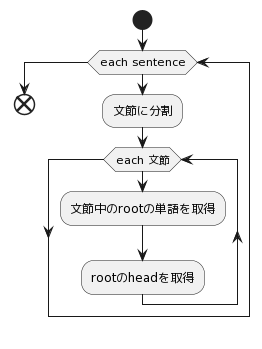

In [ ]:
with open('/content/sample.puml', 'w+') as f:
	f.write('''

@startuml
start
while (each sentence)
  :文節に分割;
  while(each 文節)
    :文節中のrootの単語を取得;
    :rootのheadを取得;
  endwhile
endwhile

end
@enduml

''')

!python -m plantuml sample.puml

from IPython.display import Image

Image('sample.png')

#### code

In [4]:
from ginza import *
from spacy import displacy
import spacy
nlp = spacy.load("ja_ginza")  # GiNZAモデルの読み込み

from collections import defaultdict
frames = defaultdict(lambda: 0)  # 依存関係の出現頻度を格納
sentences = set()  # 重複文検出用のset
txt="下流あごを2mmだすと分離は改善するが、コンタミが悪化する"
txt="非通紙部昇温時のxx75において発生する。"
txt="下流あごを出すこととオフセットを0.2mmにすることより解決する"
txt="上流あごは分離に影響を与えない。オフセットの増加は分離に関係ない"
txt_l=["下流あごを2mmだすと分離は改善するが、コンタミが悪化するので、下流アゴが重要",
         "わたしはとなりのトトロがすき",
         "非通紙部昇温時のxx75において発生する。",
         "下流あごを出すこととオフセットを0.2mmにすることより解決する",
         "上流あごは分離に影響を与えない。オフセットの増加は分離に関係ない",
         "下流あごの増加による分離悪化を説明できない",
         "下流あごと分離は無関係である",
         "オフセットと分離は関係ある",
         "上流オフセットでは分離は改善しない",
         "フィルムの気泡が大きくなるか　肉眼では見えなくなった。が、通紙で悪化しないことが確認できた",
       "クラックが少ない場合は異常高温（１つ以上のサーミスタが240℃以上）検知、クラックが多い場合は異常低温（xxWでxx℃以下）検知する"]
for txt in txt_l:
  doc = nlp(txt)  # 解析を実行し
  print(doc)
  displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})
  print("bunsetu API:bunsetu_spans")
  bunsetus=bunsetu_spans(doc)
  print(bunsetus)
  print("bunsetu API:bunsetu phrase spans")
  print(bunsetu_phrase_spans(doc))
  print("bunsetu API: bunsetu head tokens")
  print(bunsetu_head_tokens(doc))
  print("*"*10)
  for bunsetu in bunsetus:
    print(bunsetu)
    print("root",bunsetu.root)
    print("head",bunsetu.root.head)

    for token in bunsetu:
      print("**",token,token.dep_)
      # print("nbor:",token.nbor())
      print("bunsetu span",bunsetu_span(token))
      print("bunsetu phrase span",bunsetu_phrase_span(token))

  print("-"*10)

下流あごを2mmだすと分離は改善するが、コンタミが悪化するので、下流アゴが重要


bunsetu API:bunsetu_spans
[下流あごを, 2mm, だすと, 分離は, 改善するが、, コンタミが, 悪化するので、, 下流アゴが, 重要]
bunsetu API:bunsetu phrase spans
[下流あご, 2mm, だす, 分離, 改善, コンタミ, 悪化, 下流アゴ, 重要]
bunsetu API: bunsetu head tokens
[下流あご, mm, だす, 分離, 改善, コンタミ, 悪化, 下流アゴ, 重要]
**********
下流あごを
root 下流あご
head だす
** 下流あご obj
bunsetu span 下流あごを
bunsetu phrase span 下流あご
** を case
bunsetu span 下流あごを
bunsetu phrase span 下流あご
2mm
root mm
head だす
** 2 nummod
bunsetu span 2mm
bunsetu phrase span 2mm
** mm obl
bunsetu span 2mm
bunsetu phrase span 2mm
だすと
root だす
head 改善
** だす advcl
bunsetu span だすと
bunsetu phrase span だす
** と mark
bunsetu span だすと
bunsetu phrase span だす
分離は
root 分離
head 改善
** 分離 nsubj
bunsetu span 分離は
bunsetu phrase span 分離
** は case
bunsetu span 分離は
bunsetu phrase span 分離
改善するが、
root 改善
head 悪化
** 改善 advcl
bunsetu span 改善するが、
bunsetu phrase span 改善
** する aux
bunsetu span 改善するが、
bunsetu phrase span 改善
** が mark
bunsetu span 改善するが、
bunsetu phrase span 改善
** 、 punct
bunsetu span 改善するが、
bunsetu phrase span 改善
コンタミが
root コ

bunsetu API:bunsetu_spans
[わたしは, となりのトトロが, すき]
bunsetu API:bunsetu phrase spans
[わたし, となりのトトロ, すき]
bunsetu API: bunsetu head tokens
[わたし, となりのトトロ, すき]
**********
わたしは
root わたし
head すき
** わたし dislocated
bunsetu span わたしは
bunsetu phrase span わたし
** は case
bunsetu span わたしは
bunsetu phrase span わたし
となりのトトロが
root となりのトトロ
head すき
** となりのトトロ nsubj
bunsetu span となりのトトロが
bunsetu phrase span となりのトトロ
** が case
bunsetu span となりのトトロが
bunsetu phrase span となりのトトロ
すき
root すき
head すき
** すき ROOT
bunsetu span すき
bunsetu phrase span すき
----------
非通紙部昇温時のxx75において発生する。


bunsetu API:bunsetu_spans
[非通紙部昇温, 時のxx75において, 発生する。]
bunsetu API:bunsetu phrase spans
[非通紙部昇温, 時, 発生]
bunsetu API: bunsetu head tokens
[非通紙部昇温, 時, 発生]
**********
非通紙部昇温
root 非通紙部昇温
head 時
** 非通紙部昇温 acl
bunsetu span 非通紙部昇温
bunsetu phrase span 非通紙部昇温
時のxx75において
root 時
head 発生
** 時 obl
bunsetu span 時のxx75において
bunsetu phrase span 時
** の case
bunsetu span 時のxx75において
bunsetu phrase span 時
** xx75 punct
bunsetu span 時のxx75において
bunsetu phrase span 時
** に case
bunsetu span 時のxx75において
bunsetu phrase span 時
** おい fixed
bunsetu span 時のxx75において
bunsetu phrase span 時
** て fixed
bunsetu span 時のxx75において
bunsetu phrase span 時
発生する。
root 発生
head 発生
** 発生 ROOT
bunsetu span 発生する。
bunsetu phrase span 発生
** する aux
bunsetu span 発生する。
bunsetu phrase span 発生
** 。 punct
bunsetu span 発生する。
bunsetu phrase span 発生
----------
下流あごを出すこととオフセットを0.2mmにすることより解決する


bunsetu API:bunsetu_spans
[下流あごを, 出す, ことと, オフセットを, 0.2mmに, する, ことより, 解決する]
bunsetu API:bunsetu phrase spans
[下流あご, 出す, こと, オフセット, 0.2mm, する, こと, 解決]
bunsetu API: bunsetu head tokens
[下流あご, 出す, こと, オフセット, mm, する, こと, 解決]
**********
下流あごを
root 下流あご
head 出す
** 下流あご obj
bunsetu span 下流あごを
bunsetu phrase span 下流あご
** を case
bunsetu span 下流あごを
bunsetu phrase span 下流あご
出す
root 出す
head こと
** 出す acl
bunsetu span 出す
bunsetu phrase span 出す
ことと
root こと
head オフセット
** こと nmod
bunsetu span ことと
bunsetu phrase span こと
** と case
bunsetu span ことと
bunsetu phrase span こと
オフセットを
root オフセット
head する
** オフセット obj
bunsetu span オフセットを
bunsetu phrase span オフセット
** を case
bunsetu span オフセットを
bunsetu phrase span オフセット
0.2mmに
root mm
head する
** 0.2 compound
bunsetu span 0.2mmに
bunsetu phrase span 0.2mm
** mm obl
bunsetu span 0.2mmに
bunsetu phrase span 0.2mm
** に case
bunsetu span 0.2mmに
bunsetu phrase span 0.2mm
する
root する
head こと
** する acl
bunsetu span する
bunsetu phrase span する
ことより
root こと
head 解決
** こと obl
bunset

bunsetu API:bunsetu_spans
[上流あごは, 分離に, 影響を, 与えない。, オフセットの, 増加は, 分離に, 関係ない]
bunsetu API:bunsetu phrase spans
[上流あご, 分離, 影響, 与え, オフセット, 増加, 分離, 関係ない]
bunsetu API: bunsetu head tokens
[上流あご, 分離, 影響, 与え, オフセット, 増加, 分離, ない]
**********
上流あごは
root 上流あご
head 与え
** 上流あご nsubj
bunsetu span 上流あごは
bunsetu phrase span 上流あご
** は case
bunsetu span 上流あごは
bunsetu phrase span 上流あご
分離に
root 分離
head 与え
** 分離 obl
bunsetu span 分離に
bunsetu phrase span 分離
** に case
bunsetu span 分離に
bunsetu phrase span 分離
影響を
root 影響
head 与え
** 影響 obj
bunsetu span 影響を
bunsetu phrase span 影響
** を case
bunsetu span 影響を
bunsetu phrase span 影響
与えない。
root 与え
head 与え
** 与え ROOT
bunsetu span 与えない。
bunsetu phrase span 与え
** ない aux
bunsetu span 与えない。
bunsetu phrase span 与え
** 。 punct
bunsetu span 与えない。
bunsetu phrase span 与え
オフセットの
root オフセット
head 増加
** オフセット nmod
bunsetu span オフセットの
bunsetu phrase span オフセット
** の case
bunsetu span オフセットの
bunsetu phrase span オフセット
増加は
root 増加
head ない
** 増加 nsubj
bunsetu span 増加は
bunsetu phrase span 増加


bunsetu API:bunsetu_spans
[下流あごの, 増加による, 分離悪化を, 説明できない]
bunsetu API:bunsetu phrase spans
[下流あご, 増加, 分離悪化, 説明]
bunsetu API: bunsetu head tokens
[下流あご, 増加, 悪化, 説明]
**********
下流あごの
root 下流あご
head 増加
** 下流あご nmod
bunsetu span 下流あごの
bunsetu phrase span 下流あご
** の case
bunsetu span 下流あごの
bunsetu phrase span 下流あご
増加による
root 増加
head 悪化
** 増加 nmod
bunsetu span 増加による
bunsetu phrase span 増加
** に case
bunsetu span 増加による
bunsetu phrase span 増加
** よる fixed
bunsetu span 増加による
bunsetu phrase span 増加
分離悪化を
root 悪化
head 説明
** 分離 compound
bunsetu span 分離悪化を
bunsetu phrase span 分離悪化
** 悪化 obj
bunsetu span 分離悪化を
bunsetu phrase span 分離悪化
** を case
bunsetu span 分離悪化を
bunsetu phrase span 分離悪化
説明できない
root 説明
head 説明
** 説明 ROOT
bunsetu span 説明できない
bunsetu phrase span 説明
** でき aux
bunsetu span 説明できない
bunsetu phrase span 説明
** ない aux
bunsetu span 説明できない
bunsetu phrase span 説明
----------
下流あごと分離は無関係である


bunsetu API:bunsetu_spans
[下流あごと, 分離は, 無関係である]
bunsetu API:bunsetu phrase spans
[下流あご, 分離, 無関係]
bunsetu API: bunsetu head tokens
[下流あご, 分離, 無関係]
**********
下流あごと
root 下流あご
head 分離
** 下流あご nmod
bunsetu span 下流あごと
bunsetu phrase span 下流あご
** と case
bunsetu span 下流あごと
bunsetu phrase span 下流あご
分離は
root 分離
head 無関係
** 分離 nsubj
bunsetu span 分離は
bunsetu phrase span 分離
** は case
bunsetu span 分離は
bunsetu phrase span 分離
無関係である
root 無関係
head 無関係
** 無関係 ROOT
bunsetu span 無関係である
bunsetu phrase span 無関係
** で cop
bunsetu span 無関係である
bunsetu phrase span 無関係
** ある fixed
bunsetu span 無関係である
bunsetu phrase span 無関係
----------
オフセットと分離は関係ある


bunsetu API:bunsetu_spans
[オフセットと, 分離は, 関係, ある]
bunsetu API:bunsetu phrase spans
[オフセット, 分離, 関係, ある]
bunsetu API: bunsetu head tokens
[オフセット, 分離, 関係, ある]
**********
オフセットと
root オフセット
head 分離
** オフセット nmod
bunsetu span オフセットと
bunsetu phrase span オフセット
** と case
bunsetu span オフセットと
bunsetu phrase span オフセット
分離は
root 分離
head 関係
** 分離 nsubj
bunsetu span 分離は
bunsetu phrase span 分離
** は case
bunsetu span 分離は
bunsetu phrase span 分離
関係
root 関係
head ある
** 関係 obl
bunsetu span 関係
bunsetu phrase span 関係
ある
root ある
head ある
** ある ROOT
bunsetu span ある
bunsetu phrase span ある
----------
上流オフセットでは分離は改善しない


bunsetu API:bunsetu_spans
[上流オフセットでは, 分離は, 改善しない]
bunsetu API:bunsetu phrase spans
[上流オフセット, 分離, 改善]
bunsetu API: bunsetu head tokens
[上流オフセット, 分離, 改善]
**********
上流オフセットでは
root 上流オフセット
head 改善
** 上流オフセット obl
bunsetu span 上流オフセットでは
bunsetu phrase span 上流オフセット
** で case
bunsetu span 上流オフセットでは
bunsetu phrase span 上流オフセット
** は case
bunsetu span 上流オフセットでは
bunsetu phrase span 上流オフセット
分離は
root 分離
head 改善
** 分離 nsubj
bunsetu span 分離は
bunsetu phrase span 分離
** は case
bunsetu span 分離は
bunsetu phrase span 分離
改善しない
root 改善
head 改善
** 改善 ROOT
bunsetu span 改善しない
bunsetu phrase span 改善
** し aux
bunsetu span 改善しない
bunsetu phrase span 改善
** ない aux
bunsetu span 改善しない
bunsetu phrase span 改善
----------
フィルムの気泡が大きくなるか　肉眼では見えなくなった。が、通紙で悪化しないことが確認できた


bunsetu API:bunsetu_spans
[フィルムの, 気泡が, 大きく, なるか　, 肉眼では, 見えなく, なった。, が, 、通紙で, 悪化しない, ことが, 確認できた]
bunsetu API:bunsetu phrase spans
[フィルム, 気泡, 大きく, なる, 肉眼, 見え, なっ, が, 通紙, 悪化, こと, 確認]
bunsetu API: bunsetu head tokens
[フィルム, 気泡, 大きく, なる, 肉眼, 見え, なっ, が, 通紙, 悪化, こと, 確認]
**********
フィルムの
root フィルム
head 気泡
** フィルム nmod
bunsetu span フィルムの
bunsetu phrase span フィルム
** の case
bunsetu span フィルムの
bunsetu phrase span フィルム
気泡が
root 気泡
head なる
** 気泡 nsubj
bunsetu span 気泡が
bunsetu phrase span 気泡
** が case
bunsetu span 気泡が
bunsetu phrase span 気泡
大きく
root 大きく
head なる
** 大きく advcl
bunsetu span 大きく
bunsetu phrase span 大きく
なるか　
root なる
head なる
** なる ROOT
bunsetu span なるか　
bunsetu phrase span なる
** か mark
bunsetu span なるか　
bunsetu phrase span なる
** 　 dep
bunsetu span なるか　
bunsetu phrase span なる
肉眼では
root 肉眼
head 見え
** 肉眼 obl
bunsetu span 肉眼では
bunsetu phrase span 肉眼
** で case
bunsetu span 肉眼では
bunsetu phrase span 肉眼
** は case
bunsetu span 肉眼では
bunsetu phrase span 肉眼
見えなく
root 見え
head なっ
** 見え advcl
bunsetu span

bunsetu API:bunsetu_spans
[クラックが, 少ない, 場合は, 異常高温（１つ以上のサーミスタが240℃以上）, 検知、, クラックが, 多い, 場合は, 異常低温（xxWでxx℃以下）, 検知する]
bunsetu API:bunsetu phrase spans
[クラック, 少ない, 場合, 異常高温（１つ以上のサーミスタが240℃以上, 検知, クラック, 多い, 場合, 異常低温（xxWでxx℃以下, 検知]
bunsetu API: bunsetu head tokens
[クラック, 少ない, 場合, 異常高温, 検知, クラック, 多い, 場合, 異常低温, 検知]
**********
クラックが
root クラック
head 少ない
** クラック nsubj
bunsetu span クラックが
bunsetu phrase span クラック
** が case
bunsetu span クラックが
bunsetu phrase span クラック
少ない
root 少ない
head 場合
** 少ない acl
bunsetu span 少ない
bunsetu phrase span 少ない
場合は
root 場合
head 異常高温
** 場合 nsubj
bunsetu span 場合は
bunsetu phrase span 場合
** は case
bunsetu span 場合は
bunsetu phrase span 場合
異常高温（１つ以上のサーミスタが240℃以上）
root 異常高温
head 異常高温
** 異常高温 ROOT
bunsetu span 異常高温（１つ以上のサーミスタが240℃以上）
bunsetu phrase span 異常高温（１つ以上のサーミスタが240℃以上
** （ punct
bunsetu span 異常高温（１つ以上のサーミスタが240℃以上）
bunsetu phrase span 異常高温（１つ以上のサーミスタが240℃以上
** １ compound
bunsetu span 異常高温（１つ以上のサーミスタが240℃以上）
bunsetu phrase span 異常高温（１つ以上のサーミスタが240℃以上
** つ compound
bunsetu span

### 公式の方法テスト

In [ ]:
from ginza import *
import spacy
nlp = spacy.load("ja_ginza")  # GiNZAモデルの読み込み

from collections import defaultdict
frames = defaultdict(lambda: 0)  # 依存関係の出現頻度を格納
sentences = set()  # 重複文検出用のset
txt="下流あごを2mmだすと分離は改善するが、コンタミが悪化する"
doc = nlp(txt)  # 解析を実行し
# print("bunsetu API")
# print(bunsetu_spans(doc))
# print("*"*10)
for sent in doc.sents:  # 文単位でループ
  if sent.text in sentences:
    continue  # 重複文はスキップ
  sentences.add(sent.text)
  # print("sent:",sent.text)
  #bunsetu_head_tokens(sent)主要な単語のリストを出力
  print(bunsetu_head_tokens(sent))
  for t in bunsetu_head_tokens(sent):  # 文節主辞トークンのうち
    # print("文節主辞トークン",t)
    if t.pos_ not in {"ADJ", "VERB"}:
      continue  # 述語以外はスキップ
    v = phrase(lemma_)(t)  # 述語とその格要素(主語・目的語相当)の句を集める.lemma形式に変換
    #vの出力lemma形式
    # print(v,t.text)

    dep_phrases = sub_phrases(t, phrase(lemma_), is_not_stop)
    # 従属文節を指定された形で整形 (dep_phrasesはdep,textのtupleのリストを返す=[(dep,text)])
    # print("従属文節を指定された形で整形")
    # print(t,dep_phrases)
    # print("chk content")
    # for i,j in dep_phrases:
    #   print(i,j)
    # subj = [phrase for dep, phrase in dep_phrases if dep in {"nsubj"}] #元コード
    subj = [phrase for dep, phrase in dep_phrases ]
    # print("主語:",subj)
    # obj  = [phrase for dep, phrase in dep_phrases if dep in {"obj", "iobj"}]#元コード
    obj  = [phrase for dep, phrase in dep_phrases ]
    # print("目的語：",obj)
    print("v",v)
    for s in subj:
      print("s",s)
      for o in obj:
        print("o",o)
        frames[(s, o, v)] += 1  # 格要素と述語の組み合わせをカウント
        print("s,v,o",frames)
print(frames)
for frame, count in sorted(frames.items(), key=lambda t: -t[1]):
  print(count, *frame, sep="\t")  # 出現頻度の高い順に表示

bunsetu API
[下流あごを, 2mm, だすと, 分離は, 改善するが、, コンタミが, 悪化する]
**********
[あご, mm, だす, 分離, 改善, コンタミ, 悪化]
v だす
s 下流+あご
o 下流+あご
s,v,o defaultdict(<function <lambda> at 0x79dbdbc012d0>, {('下流+あご', '下流+あご', 'だす'): 1})
o 2+mm
s,v,o defaultdict(<function <lambda> at 0x79dbdbc012d0>, {('下流+あご', '下流+あご', 'だす'): 1, ('下流+あご', '2+mm', 'だす'): 1})
s 2+mm
o 下流+あご
s,v,o defaultdict(<function <lambda> at 0x79dbdbc012d0>, {('下流+あご', '下流+あご', 'だす'): 1, ('下流+あご', '2+mm', 'だす'): 1, ('2+mm', '下流+あご', 'だす'): 1})
o 2+mm
s,v,o defaultdict(<function <lambda> at 0x79dbdbc012d0>, {('下流+あご', '下流+あご', 'だす'): 1, ('下流+あご', '2+mm', 'だす'): 1, ('2+mm', '下流+あご', 'だす'): 1, ('2+mm', '2+mm', 'だす'): 1})
v 改善
s だす
o だす
s,v,o defaultdict(<function <lambda> at 0x79dbdbc012d0>, {('下流+あご', '下流+あご', 'だす'): 1, ('下流+あご', '2+mm', 'だす'): 1, ('2+mm', '下流+あご', 'だす'): 1, ('2+mm', '2+mm', 'だす'): 1, ('だす', 'だす', '改善'): 1})
o 分離
s,v,o defaultdict(<function <lambda> at 0x79dbdbc012d0>, {('下流+あご', '下流+あご', 'だす'): 1, ('下流+あご', '2+mm', 'だす'): 1, ('2+

## test

In [ ]:
from ginza import *
import spacy
nlp = spacy.load("ja_ginza")
doc = nlp("下流あごを2mmだすと分離は改善するが、コンタミが悪化する")
# doc = nlp("赤い車を持っている")
# print("文節")
for sent in doc.sents:
  print(sent.text)
  print("-"*10)
  for index,token in enumerate(sent):
    print(index,token.text)
# print(doc[5].text)
# token = doc[5] # 改善するのトークン

# print(doc[9].text)
# token = doc[9] # 改善するのトークン
print(doc[15].text)
token = doc[15] # 改善するのトークン
# token.childrenの例
print("token.children:")
for child in token.children:
    print(child.text)

# token.subtreeの例
print("token.subtree:")
for descendant in token.subtree:
    print(descendant.text)


下流あごを2mmだすと分離は改善するが、コンタミが悪化する
----------
0 下流
1 あご
2 を
3 2
4 mm
5 だす
6 と
7 分離
8 は
9 改善
10 する
11 が
12 、
13 コンタミ
14 が
15 悪化
16 する
悪化
token.children:
改善
コンタミ
する
token.subtree:
下流
あご
を
2
mm
だす
と
分離
は
改善
する
が
、
コンタミ
が
悪化
する


In [ ]:
# GiNZAをインポート
import spacy
import ginza

# GiNZAのモデルをロード
nlp = spacy.load("ja_ginza")

# 文章を分析
text = "下流あごを2mmだすと分離は改善するが、コンタミが悪化する。"
doc = nlp(text)

# 主語、述語、目的語のセットを表示
print("主語、述語、目的語のセット:")
for token in doc:
    # 述語を探す

    if token.dep_ in ("root", "acl", "advcl", "conj"):
        # 主語を探す
        subject = None
        for child in token.children:
            if child.dep_ in ("nsubj", "csubj"):
                # 主語の範囲を拡張する
                # 修正箇所：subtreeではなくleft_edgeとright_edgeを使ってスパンを作る
                subject = child.subtree
                break
        # 目的語を探す
        object = None
        for child in token.children:
            if child.dep_ in ("obj", "iobj"):
                # 目的語の範囲を拡張する
                # 修正箇所：subtreeではなくleft_edgeとright_edgeを使ってスパンを作る
                object = child.subtree
                break
        # 主語、述語、目的語のセットを表示
        if subject is not None:
            subject_text = ''.join([t.text for t in subject])
        else:
            subject_text = 'なし'
        if object is not None:
            object_text = ''.join([t.text for t in object])
        else:
            object_text = 'なし'
        print(f"- 主語: {subject_text}、述語: {token}、目的語: {object_text}")

主語、述語、目的語のセット:
- 主語: なし、述語: だす、目的語: 下流あごを
- 主語: 分離は、述語: 改善、目的語: なし
